# pm25 Simulations for Podkarpacie

Run these cells if this notebook is run on Google Colab

In [23]:
# !pip install unidecode
# !pip install scikit-gstat

In [24]:
# import os

# from google.colab import drive

# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive')

Mount this colab notebook to your drive and change the directory to it. Within you should have the following files:
- **pm25.csv**
- **zipfolder** with:
  - Wszystkie.cpg
  - Wszystkie.dbf
  - Wszystkie.prj
  - Wszystkie.sbn
  - Wszystkie.sbx
  - Wszystkie.shp
  - Wszystkie.shx


This is a list of cities in Podkarpacie voivodeship that we will use for our simulations

In [25]:
cities = [
    'Tarnobrzeg',
    'Sanok',
    'Rzeszow',
    'Rymanow',
    'Przemysl',
    'Nisko',
    'Mielec',
    'Krosno',
    'Jaslo',
    'Jaroslaw',
    'Debica',
    'Jedlicze'
 ]

## pm25 DataFrame Preprocessing

In [26]:
import pandas as pd

pm25_df = pd.read_csv('pm25.csv', index_col=0)

Let's take a look at our dataset

In [27]:
pm25_df.head()

,Data,Rzeszow,Rymanow_Zdroj,Przemysl,Nisko,Mielec,Krosno,Jaslo,Jaroslaw,Debica,Rzeszow_Starzynskiego,Rzeszow_Slocinska,Rzeszow_Pilsudskiego,Jedlicze
2022-12-22 01:00,15.8,11.8,15.2,26.8,19.6,11.6,12.7,21.8,15.0,NaN,NaN,NaN,NaN,NaN
2022-12-22 02:00,14.8,12.4,13.6,25.6,19.9,13.2,14.3,23.9,20.7,NaN,NaN,NaN,NaN,NaN
2022-12-22 03:00,15.6,11.9,10.3,21.6,15.7,15.5,13.6,12.9,14.3,NaN,NaN,NaN,NaN,NaN
2022-12-22 04:00,14.4,11.6,7.7,22.0,13.9,12.7,10.7,8.6,12.9,NaN,NaN,NaN,NaN,NaN
2022-12-22 05:00,12.9,12.0,6.6,18.7,13.6,11.9,16.0,8.5,12.4,NaN,NaN,NaN,NaN,NaN


In [28]:
pm25_df.dtypes

Data                     float64
Rzeszow                   object
Rymanow_Zdroj             object
Przemysl                  object
Nisko                     object
Mielec                    object
Krosno                    object
Jaslo                    float64
Jaroslaw                  object
Debica                   float64
Rzeszow_Starzynskiego     object
Rzeszow_Slocinska         object
Rzeszow_Pilsudskiego      object
Jedlicze                  object
dtype: object

All of our values should be floats. To fix this we will replace the empty strings with `np.nan` and cast everything to `float`

In [29]:
import numpy as np


pm25_df = pm25_df.replace(' ', np.nan)
pm25_df = pm25_df.replace('  ', np.nan)
pm25_df = pm25_df.astype(float)

Now we can see how many missing values there are

In [30]:
pm25_df.isna().sum()

Data                        0
Rzeszow                  1371
Rymanow_Zdroj               5
Przemysl                   21
Nisko                       8
Mielec                     67
Krosno                      4
Jaslo                       0
Jaroslaw                   21
Debica                   2136
Rzeszow_Starzynskiego     780
Rzeszow_Slocinska         773
Rzeszow_Pilsudskiego      778
Jedlicze                  823
dtype: int64

`Rzeszow` has a high number of missing values and `Debica` doesn't contain any single real value, so we will drop them.

In [31]:
pm25_df = pm25_df.drop(["Rzeszow", "Debica"], axis=1)

For columns with small amount of missing values we will replace them with mean value of that column.

In [32]:
pm25_df = pm25_df.fillna(pm25_df.mean())

Lastly let's set the index to `Data` column

In [33]:
pm25_df = pm25_df.set_index('Data')

## Cities Geopandas DataFrame Preprocessing

Next let's load our shapefile with cities data

In [34]:
import geopandas as gpd

shapefile_path = "miasta/Wszystkie.shp"

gdf = gpd.read_file(shapefile_path)

gdf.head()

,INFO,STATION_CO,STATION_NA,ADDRESS,geometry
0,automatyczno-manualny,PmKosTargowa,"Kościerzyna, ul. Targowa","Kościerzyna, ul. Targowa",POINT (17.97586 54.12069)
1,automatyczny,PmMalMickiew,"Malbork, ul. Mickiewicza","Malbork, ul. Mickiewicza",POINT (19.03290 54.03125)
2,automatyczno-manualny,PmLebMalczew,"Lębork, ul. Malczewskiego","Lębork, ul. Malczewskiego",POINT (17.74619 54.54617)
3,automatyczny,PmLinieKosci,Liniewko Kościerskie,"Liniewko Kościerskie,",POINT (18.18297 54.10411)
4,automatyczny,KpBydPlPozna,"Bydgoszcz, pl. Poznański","Bydgoszcz, Plac Poznański",POINT (17.98791 53.12176)


As we can many of our values have polish characters. We will fix that by using `unidecode`

In [35]:
from unidecode import unidecode

for col in gdf.select_dtypes(include=[object]):
    gdf[col] = gdf[col].apply(unidecode)

Now we can see how many of our `cities` are within the `gdf` dataframe

In [36]:
for city in cities:
    print(gdf[gdf['STATION_NA'].str.contains(city)]['STATION_NA'].unique())

['Tarnobrzeg, ul. Dabrowskiej']
['Sanok, ul. Sadowa']
['Rzeszow, ul. Rejtana' 'Rzeszow, ul. Pilsudskiego'
 'Rzeszow, ul. Starzynskiego' 'Rzeszow, ul. Slocinska']
['Rymanow Zdroj, ul. Parkowa']
['Szczecinek, ul. Przemyslowa' 'Przemysl, ul. Grunwaldzka']
['Nisko, ul. Szklarniowa']
['Mielec, ul. Biernackiego' 'Mielec, ul. Pogodna']
['Krosno, ul. Kletowki']
['Jaslo, ul. Sikorskiego']
['Jaroslaw, ul. Pruchnicka']
['Debica, ul.Grottgera']
['Jedlicze, ul. Tokarskich']


We will take a subset from our dataframe with only these adresses. To do so let's create a flat list with these values

In [37]:
addresses = [gdf[gdf['STATION_NA'].str.contains(city)]['STATION_NA'].unique() for city in cities]

Here we use `itertools` to flatten our list

In [38]:
import itertools

addresses = list(itertools.chain.from_iterable(addresses))

And lastly we get rid of Szczecinek

In [39]:
addresses = [addresse for addresse in addresses if addresse != 'Szczecinek, ul. Przemyslowa']

In [40]:
addresses

['Tarnobrzeg, ul. Dabrowskiej',
 'Sanok, ul. Sadowa',
 'Rzeszow, ul. Rejtana',
 'Rzeszow, ul. Pilsudskiego',
 'Rzeszow, ul. Starzynskiego',
 'Rzeszow, ul. Slocinska',
 'Rymanow Zdroj, ul. Parkowa',
 'Przemysl, ul. Grunwaldzka',
 'Nisko, ul. Szklarniowa',
 'Mielec, ul. Biernackiego',
 'Mielec, ul. Pogodna',
 'Krosno, ul. Kletowki',
 'Jaslo, ul. Sikorskiego',
 'Jaroslaw, ul. Pruchnicka',
 'Debica, ul.Grottgera',
 'Jedlicze, ul. Tokarskich']

Now with our list we can create a subset `gdf_podkarpacie`

In [44]:
gdf_podkarpacie = gdf.loc[gdf['STATION_NA'].isin(addresses)]
gdf_podkarpacie = gdf_podkarpacie.drop(['INFO', 'STATION_CO', 'ADDRESS'], axis=1)
gdf_podkarpacie.head()

,STATION_NA,geometry
35,"Jaslo, ul. Sikorskiego",POINT (21.45462 49.74489)
36,"Krosno, ul. Kletowki",POINT (21.74970 49.69017)
37,"Nisko, ul. Szklarniowa",POINT (22.11247 50.52989)
121,"Sanok, ul. Sadowa",POINT (22.19589 49.57173)
122,"Tarnobrzeg, ul. Dabrowskiej",POINT (21.68837 50.57574)


With our subset now we want to unify the adresses with our `pm25_df` column names.
We will start by matching the first value in column name which is the city

In [45]:
gdf_podkarpacie_cities = gdf_podkarpacie.copy()

for address in addresses:
    matched_city = next((city for city in cities if city.split('_')[0] in address), None)
    if not matched_city or len(matched_city.split('_')) > 1:
        continue

    gdf_podkarpacie_cities.loc[gdf_podkarpacie_cities['STATION_NA'] == address, 'STATION_NA'] = matched_city

gdf_podkarpacie_cities

,STATION_NA,geometry
35,Jaslo,POINT (21.45462 49.74489)
36,Krosno,POINT (21.74970 49.69017)
37,Nisko,POINT (22.11247 50.52989)
121,Sanok,POINT (22.19589 49.57173)
122,Tarnobrzeg,POINT (21.68837 50.57574)
136,Jaroslaw,POINT (22.67477 50.01208)
170,Przemysl,POINT (22.75624 49.78434)
171,Rzeszow,POINT (22.01058 50.02424)
185,Debica,POINT (21.41626 50.05479)
188,Mielec,POINT (21.44094 50.29913)


Next we will match the second value which is the street

In [46]:
for address in addresses:
    matched_city = next((city for city in cities if city.split('_')[-1] in address), None)
    if not matched_city:
        continue

    gdf_podkarpacie_cities.loc[gdf_podkarpacie_cities['STATION_NA'] == address, 'STATION_NA'] = matched_city

gdf_podkarpacie_cities

,STATION_NA,geometry
35,Jaslo,POINT (21.45462 49.74489)
36,Krosno,POINT (21.74970 49.69017)
37,Nisko,POINT (22.11247 50.52989)
121,Sanok,POINT (22.19589 49.57173)
122,Tarnobrzeg,POINT (21.68837 50.57574)
136,Jaroslaw,POINT (22.67477 50.01208)
170,Przemysl,POINT (22.75624 49.78434)
171,Rzeszow,POINT (22.01058 50.02424)
185,Debica,POINT (21.41626 50.05479)
188,Mielec,POINT (21.44094 50.29913)


Lastly we will drop the rows which weren't matched. These rows will contatain a comma

In [47]:
for city in gdf_podkarpacie_cities['STATION_NA']:
    if "," in city:
        gdf_podkarpacie_cities = gdf_podkarpacie_cities.drop(gdf_podkarpacie_cities[gdf_podkarpacie_cities['STATION_NA'] == city].index)

Some of our cities are duplicated. We don't need this much inforamtion so we will drop them

In [48]:
gdf_podkarpacie_cities = gdf_podkarpacie_cities.drop_duplicates(subset=['STATION_NA'])

Now let's see how our processed dataframe looks

In [49]:
gdf_podkarpacie_cities

,STATION_NA,geometry
35,Jaslo,POINT (21.45462 49.74489)
36,Krosno,POINT (21.74970 49.69017)
37,Nisko,POINT (22.11247 50.52989)
121,Sanok,POINT (22.19589 49.57173)
122,Tarnobrzeg,POINT (21.68837 50.57574)
136,Jaroslaw,POINT (22.67477 50.01208)
170,Przemysl,POINT (22.75624 49.78434)
171,Rzeszow,POINT (22.01058 50.02424)
185,Debica,POINT (21.41626 50.05479)
188,Mielec,POINT (21.44094 50.29913)


## Visual analysis

Let's see how our cities are spatialy distributed on a simple plot

<Axes: >

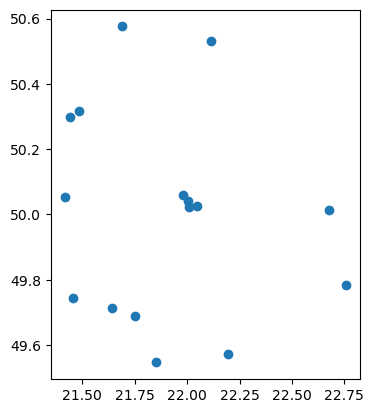

In [50]:
gdf_podkarpacie.plot()

### Variograms
Now let's investigate how few of our Variograms would look. Let's take the first 5 rows from our `pm25_df`

/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


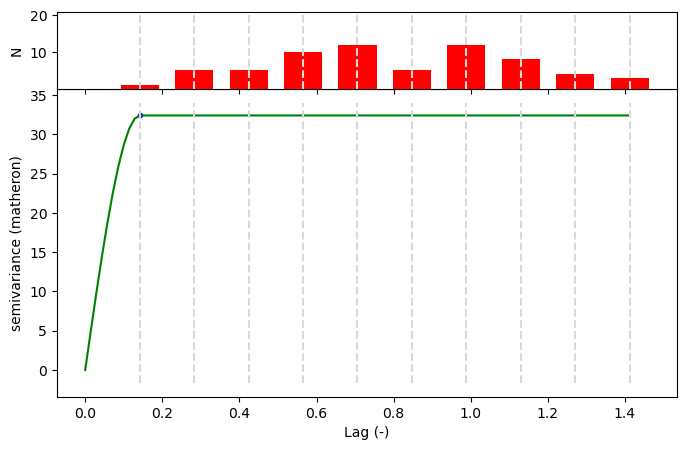

/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


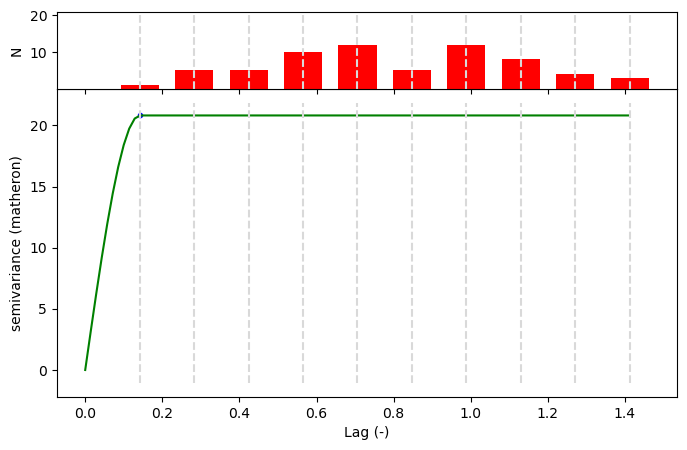

/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


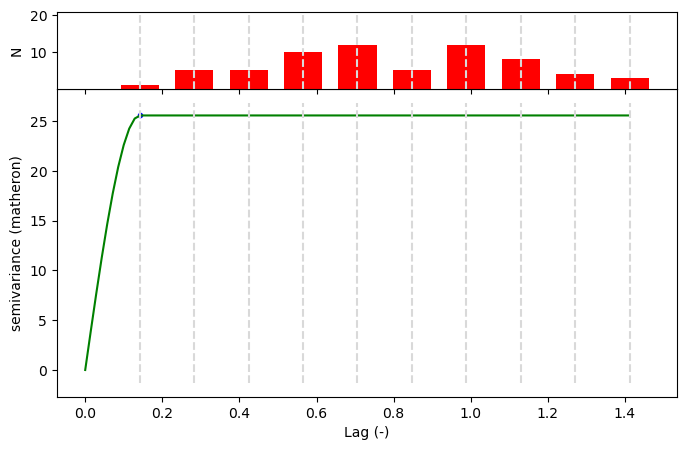

/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


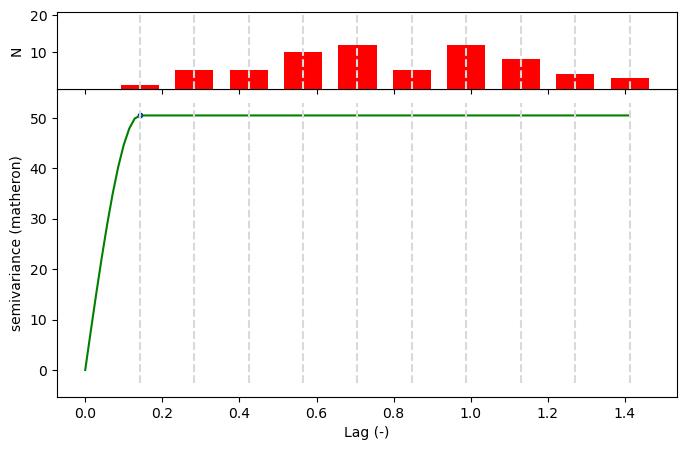

/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/student/.conda/envs/proc-stoc/lib/python3.11/site-packages/skgstat/plotting/variogram_plot.py:123: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


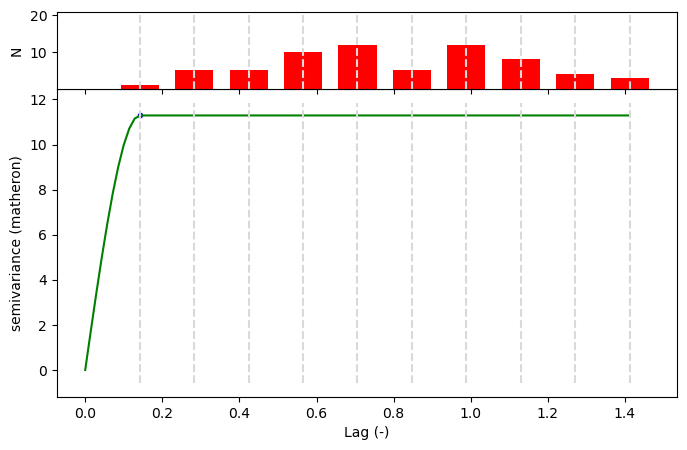

In [71]:
from skgstat import Variogram
import matplotlib.pyplot as plt

coordinates = gdf_podkarpacie_cities['geometry'].apply(lambda p: (p.x, p.y)).tolist()

for _, row in pm25_df.head().iterrows():
    row.name = "contamination"
    data = gdf_podkarpacie_cities.join(row, on='STATION_NA')

    values = list(map(float, data['contamination'].tolist()))

    V = Variogram(coordinates, values, model='spherical', maxlag=50, n_lags=10)

    fig = V.plot()
    plt.show()

### Interpolation function

All of our coordinates will stay the same for all rows, so we can define maximum and minimum values here.
We will also calculate the meshgrid for interpolations, as it will also stay the same

In [72]:
max_x = max(point.x for point in gdf_podkarpacie_cities['geometry']) + .1
max_y = max(point.y for point in gdf_podkarpacie_cities['geometry']) + .1
min_x = min(point.x for point in gdf_podkarpacie_cities['geometry']) - .1
min_y = min(point.y for point in gdf_podkarpacie_cities['geometry']) - .1

xx, yy = np.mgrid[min_x:max_x:100j, min_y:max_y:100j]

In [73]:
import skgstat as skg


def interpolate(V):
    ok = skg.OrdinaryKriging(V, min_points=1, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    return field

### Kriging plot

We chose one point of interest which is a [Biedronka grocery store in Strzyzow](https://maps.apple.com/place?q=Biedronka&auid=334584916135679909&address=W%20Witosa%2017,%2038-100%20Strzy%C5%BC%C3%B3w,%20Poland&ll=49.8700714,21.7989596).
We will calculate interpolations and statistics for this single point

In [74]:
x_biedronka = 21.79
y_biedronka = 49.87

Let's plot one kriging and add cities with our Biedronka to it

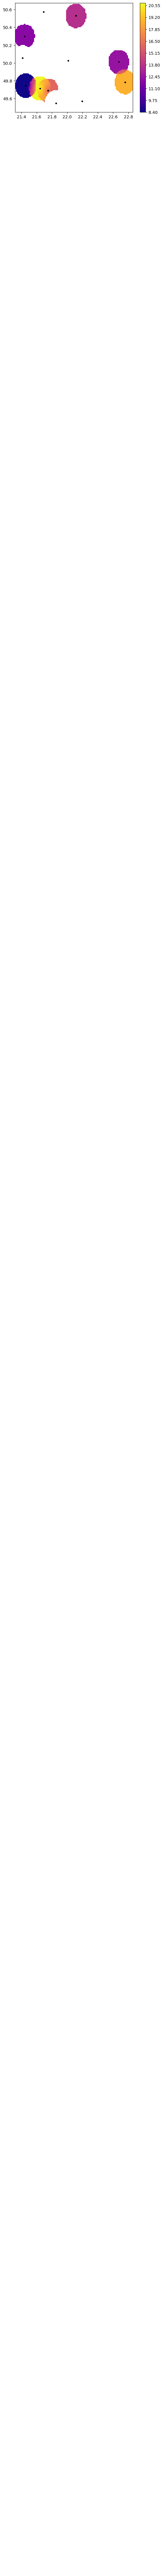

In [75]:
values = interpolate(V)

plt.contourf(xx, yy, values, 100, cmap='plasma')
plt.plot(gdf_podkarpacie_cities['geometry'].x, gdf_podkarpacie_cities['geometry'].y, 'k.')
plt.plot([x_biedronka], [y_biedronka], 'w.')
plt.text(x_biedronka, x_biedronka, 'biedronka', c='w')
plt.colorbar()

To find the interpolation values for our point we need to find the indexes in meshgrid

In [ ]:
tolerance = 1e-2
x_index = np.where(np.abs(xx - x_biedronka) < tolerance)[0][0]
y_index = np.where(np.abs(yy - y_biedronka) < tolerance)[0][0]

### Single point interpolation function
Now we can define a function that will return the value for our single point

In [ ]:
def interpolate_single_point(V):
    ok = skg.OrdinaryKriging(V, min_points=1, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    return field[x_index][y_index]

## Simulation calculations
Now for each row we calulate the interpolation values for our point

In [ ]:
kriging_values = []

for index, row in pm25_df.iterrows():
    row.name = "contamination"
    data = gdf_podkarpacie_cities.join(row, on='STATION_NA')
    coordinates = gdf_podkarpacie_cities['geometry'].apply(lambda p: (p.x, p.y)).tolist()

    values = list(map(float, data['contamination'].tolist()))

    try:
      V = Variogram(coordinates, values, model='spherical', maxlag=20, n_lags=10)
    except RuntimeError as e:
      print(f"Error for row {index}:\n{e}")
      continue

    value = interpolate_single_point(V)
    kriging_values.append(value)

## Statistics

Now with many calculated kriging values for our point we can calculate some statistics and probability of this point value being above the 3rd quartile

In [ ]:
# Remove nans from krigin values
kriging_values = [value for value in kriging_values if not np.isnan(value)]

1329

Let's see how many samples we have

In [ ]:
print(f"Number of samples: {len(kriging_values)}")

Number of samples: 1030


Next let's calculate some statistics for our point

In [ ]:
kriging_values_mean = np.mean(kriging_values)

kriging_values_std = np.std(kriging_values)

kriging_values_upper = kriging_values_mean + kriging_values_std
kriging_values_lower = kriging_values_mean - kriging_values_std

kriging_values_q1 = np.quantile(kriging_values, 0.25)
kriging_values_q2 = np.quantile(kriging_values, 0.5)
kriging_values_q3 = np.quantile(kriging_values, 0.75)

In [ ]:
print(f"Mean:               {kriging_values_mean:.4f}")
print(f"Standard deviation: {kriging_values_std:.4f}")
print(f"Upper bound:        {kriging_values_upper:.4f}")
print(f"Lower bound:        {kriging_values_lower:.4f}")
print(f"Q1:                 {kriging_values_q1:.4f}")
print(f"Q2:                 {kriging_values_q2:.4f}")
print(f"Q3:                 {kriging_values_q3:.4f}")
print(f"Min:                {min(kriging_values):.4f}")
print(f"Max:                {max(kriging_values):.4f}")

Mean:               13.5771
Standard deviation: 6.7315
Upper bound:        20.3086
Lower bound:        6.8456
Q1:                 8.6824
Q2:                 12.2124
Q3:                 16.8476
Min:                3.3000
Max:                38.9181


It will be easier to see on some plots

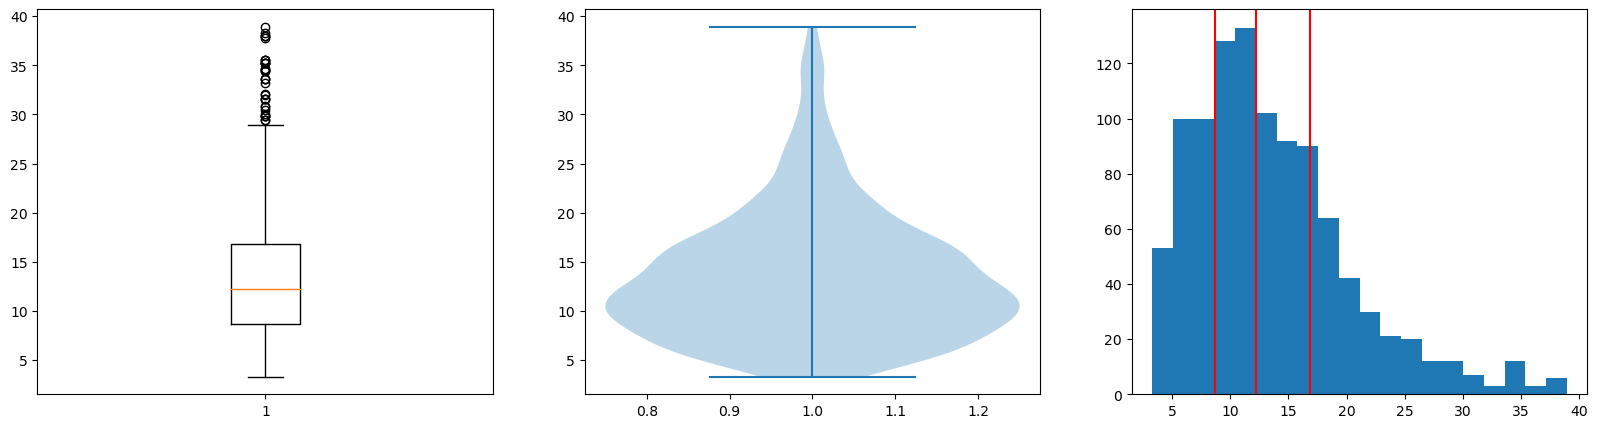

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].boxplot(kriging_values)

axes[1].violinplot(kriging_values)

axes[2].hist(kriging_values, bins=20)
axes[2].axvline(kriging_values_q1, color='red')
axes[2].axvline(kriging_values_q2, color='red')
axes[2].axvline(kriging_values_q3, color='red')

## Results
Finally let's calcualate the probability of the value being greater than the 3rd quartile

In [ ]:
probability = len([value for value in kriging_values if value > kriging_values_q3]) / len(kriging_values)
print(f"Probability: {probability:.4f}")

Probability: 0.2495
